<a href="https://colab.research.google.com/github/Sanvireddy/DS403/blob/main/Pr_Assg3(GMM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing required libraries
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


In [ ]:
#Function to read data on given path into a dataframe
def read_data(file_path):
  data = pd.read_csv(file_path, sep=',', header=None)
  #Make list of empty columns
  empty_cols = [col for col in data.columns if data[col].isnull().all()]
  # Drop these columns from the dataframe
  data.drop(empty_cols, axis=1, inplace=True) 
  #Return dataframe
  return data


In [ ]:
#Function to determine loss/error
def loss_function(data, means, sigmas, pi):
  loss = 0
  for i in range(len(data)):
    temp = 0
    for j in range(n_clusters):
      #calculating pdf for multivariate normal of data sample
      temp = temp + pi[j]*mvn.pdf(data.iloc[i], means[j], sigmas[j])
    #adding up of total loss
    loss = loss+np.log(temp)
  return loss


In [ ]:
#Function to acquire required GMM parameters
def init_GMM(data, n_clusters):
  #initialising means, sigmas, pi arrays with zeros
  dim = len(data.columns)
  means = np.zeros((n_clusters, dim))
  sigmas = np.zeros((n_clusters, dim, dim))
  pi = np.zeros(n_clusters)

  #performing kmeans on the data with n_clusters
  kmeans = KMeans(init="random", n_clusters=n_clusters, max_iter=300)
  kmeans.fit(data)
  predictions = kmeans.predict(data)

  #for loop to add the respective elements to the initialised arrays
  for i in range(n_clusters):
    #finding means of each cluster
    means[i] = data.iloc[np.where(predictions==i)].mean()
    idx = np.where(predictions==i)

    #(x-mu), x being each data  sample
    x = data.iloc[idx] - means[i]
    
    #covariance(sigma)=(x-mu)T.(x-mu)/len(x)
    sigmas[i,:, :] = np.dot((x).T, (x)) / len(idx)
    pi[i] = len(data.iloc[np.where(predictions==i)])/len(data)
  return means, sigmas, pi

In [ ]:
# Expectation step
# evaluating the responsibilities using the current parameter values
def e_step(data, means, sigmas, pi):
  # finding the number of clusters
  n_clusters = len(means)

  # initiate 2d array and every value is zero 
  # len(data) number of rows and n_clusters number of columns
  gamma = np.zeros((len(data),n_clusters))
  

  for i in range(n_clusters):
    sum = 0
    for j in range(len(data)):

      # mean[i], sigmas[i] are the mean and sigma of ith gaussian
      # pi[i] is the mixing coefficient of the ith guassian
      gamma[j][i] = pi[i]*mvn.pdf(data.iloc[j], means[i], sigmas[i])
      sum = sum+gamma[j][i]
      
    # evaluating the responsibility for ith column
    gamma[:,i] = gamma[:,i]/sum
  return gamma

In [ ]:
# Maximisation step
# re-estimating the parameters using the current responsibilities

def m_step(data, gamma, means, sigmas, pi):
  n_clusters = len(means)
  for i in range(n_clusters):
    nk = np.sum(gamma[:,i])

    # new mixing coefficients
    pi[i] = nk/len(data)

    # new means
    means[i] = (1/nk)*(np.dot(gamma[:,i].T,data.iloc[:]))
    
    temp = np.matrix(np.array(data) - means[i, :])

    # new variances
    sigmas[i] = temp.T * np.diag(gamma[:,i]) * temp

  return means, sigmas, pi


In [ ]:
def gmm(n_clusters, data, iters):

  # initialising mean, sigma and mixing coefficient for n clusters
  means, sigmas, pi = init_GMM(data, n_clusters)

  # finding the cost 
  cost = loss_function(data, means, sigmas, pi)
  cost_prev = 0
  iter = 0

  # check for convergence of either the parameters or cost-function
  # if not satisfied return to e-step
  while(abs(cost-cost_prev)>0.00001 and iter<iters):
    cost_prev = cost

    # E step.
    # Evaluate the responsibilities using the current parameter values
    gamma = e_step(data, means, sigmas, pi)

    # M step.
    # Re-estimate the parameters using the current responsibilities
    means, sigmas, pi = m_step(data, gamma, means, sigmas, pi)

    # Evaluate the log likelihood
    cost = loss_function(data, means, sigmas, pi)
    iter = iter+1
  return means, sigmas, pi

In [ ]:
def predict(means1, sigmas1, pi1, means2, sigmas2, pi2, x,n_clusters):
  p1 = 0
  p2 = 0
  for i in range(n_clusters):
    p1 = p1+pi1[i]*mvn.pdf(x, means1[i], sigmas1[i])
    
  for i in range(n_clusters):
    p2 = p2+pi2[i]*mvn.pdf(x, means2[i], sigmas2[i])  

  if(p1>p2):
    return 0
  else:
    return 1


In [ ]:
if __name__ == '__main__':
  df1 = read_data(r'/content/Class1.txt')
  df2 = read_data(r'/content/class2.txt')
  
  df1_train, df1_test = train_test_split(df1, test_size=0.33, random_state=42)
  df2_train, df2_test = train_test_split(df2, test_size=0.33, random_state=42)

  plt.figure()
  plt.scatter(df1_train[[0]],df1_train[[1]],label="Class1")
  plt.scatter(df2_train[[0]],df2_train[[1]],label="Class2")
  plt.title("Original Distribution of training data")

  plt.figure()
  plt.scatter(df1_test[[0]],df1_test[[1]],label="Class1")
  plt.scatter(df2_test[[0]],df2_test[[1]],label="Class2")
  plt.title("Original Distribution of test data")

  n_clusters = 2
  iters = 400

  means1, sigmas1, pi1 = gmm(n_clusters, df1_train, iters)
  means2, sigmas2, pi2 = gmm(n_clusters, df2_train, iters)
  plt.figure()
  plt.scatter(df1_train[[0]],df1_train[[1]],label="Class1")
  plt.scatter(df2_train[[0]],df2_train[[1]],label="Class2")
  plt.title("Original Distribution of training data")

  plt.figure()
  # plt.scatter(df2_train[[0]],df2_train[[1]],label="Class1")
  

  accuracy = 0
  for i in range(len(df1_test)):
    x = np.array(df1_test.iloc[i])
    if(predict(means1, sigmas1, pi1, means2, sigmas2, pi2, x,n_clusters)==0):
      plt.scatter(x[0],x[1],label="Class1",c='lightblue')
      accuracy = accuracy+1
    else: 
      plt.scatter(x[0],x[1],label="Class2",c='lightpink')

  for i in range(len(df2_test)):
    x = np.array(df2_test.iloc[i])
    if(predict(means1, sigmas1, pi1, means2, sigmas2, pi2, x,n_clusters)==1):
      plt.scatter(x[0],x[1],label="Class2",c='lightpink')
      accuracy = accuracy+1
    else: 
      plt.scatter(x[0],x[1],label="Class1",c='lightblue')
    
  plt.scatter(means2[0][0],means2[0][1],c='r')
  plt.scatter(means2[1][0],means2[1][1],c='b')
  plt.scatter(means1[0][0],means1[0][1],c='r')
  plt.scatter(means1[1][0],means1[1][1],c='b')
  accuracy = accuracy/(len(df1_test)+len(df2_test))
  print("Accuracy on test data is : ",accuracy*100)



NameError: ignored

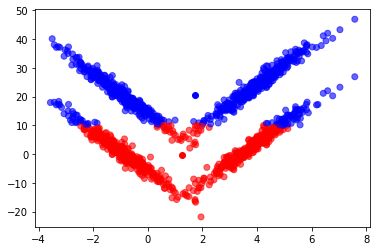

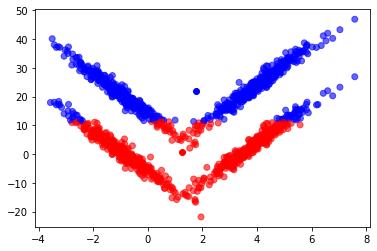

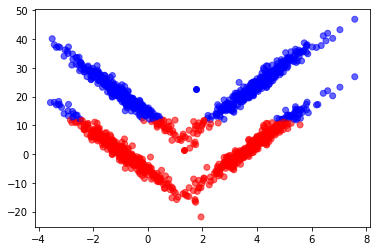

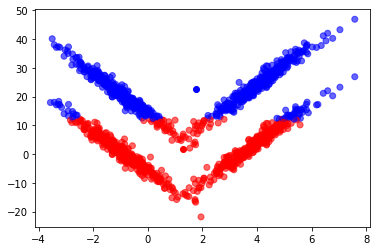

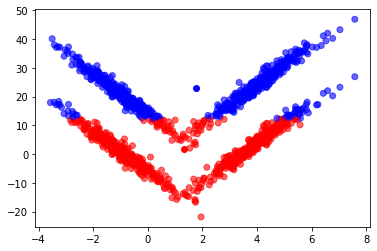

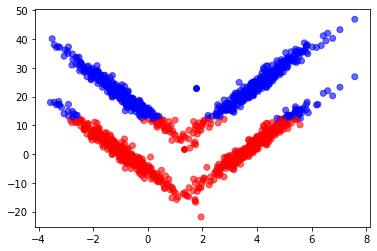

91.5


In [ ]:
#importing all the required modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
pd.options.mode.chained_assignment = None


# defining a function which calculates the percentage accuracy
def percentage_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)*100


# importing the data 
df1 = pd.read_csv(r"/content/class1.txt", header=None, names=["x","y"])
df2 = pd.read_csv(r"/content/class2.txt", header=None, names=["x","y"])
train = df1.append(df2)



labels1 = [0]*len(df1)
labels2 = [1]*len(df2)
labels = labels1 + labels2
test = np.array(labels)


test=pd.DataFrame(test,columns=["class"])
X_train, X_test, y_train, y_test = train_test_split(train,test, test_size=0.30, random_state=42)
x = X_train["x"]
y = X_train["y"]
df = X_train


colmap = {1: 'r', 2: 'b',3:'g',4:'y'}
np.random.seed(200)
k = 2


# storing random x,y values in a dictionary as centroids
centroids={}
for i in range(k):
    centroids[i+1]=[np.random.randint(min(x),max(x)), np.random.randint(min(y),max(y))]
  
    
# function to assign data points to 'k' clusters
def assignment(df, centroids):
    
    # evaluating the distance of data points from each cluster
    
    for i in centroids.keys():
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x'] - centroids[i][0]) ** 2
                + (df['y'] - centroids[i][1]) ** 2
            )
        )
    

    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    
   
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    # this will store the minimum distance between the data point and clustser center
    # and also from which cluster it is nearer to as "distance_from_{clustercentre}"
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    
    # this will map the cluster centre to its assigned colour
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df

df = assignment(df, centroids)


# function for updating the centroids as mean of the data points in the cluster
def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['x'])
        centroids[i][1] = np.mean(df[df['closest'] == i]['y'])
    return k



while True:
    # Make a deep copy, including a copy of the data and the indices
    closest_centroids = df['closest'].copy(deep=True)
    
    #update the cluster centres
    centroids = update(centroids)
    
    # assign the data points to different clusters
    #calling kmeans with updated centroids
    df = assignment(df, centroids)
    
    # if the previously assigned cluster and the cluster which is assigned now
    # are equal for all the data points 
    # then break the loop
    # else continue updating the cluster centres
    if closest_centroids.equals(df['closest']):
        break

    # plotting the data points
    plt.figure()
    plt.scatter(df['x'], df['y'], color=df['color'], alpha=0.6)
    for i in centroids.keys():
        plt.scatter(*centroids[i], color=colmap[i])
    plt.show()



count0 = 0
count1 = 0
#print(df.head())
#print(y_train)


for i,j in zip(df["closest"],y_train):
  if(i == 1 and j == 0):
   count0 = count0 + 1
  if(i == 1 and j == 1):
    count1 = count1 + 1

df1 = assignment(X_test, centroids)
df1['closest']-=1
#print(df1)

y_pred = (df1["closest"]).to_numpy()
y_true = (y_test).to_numpy()
print(percentage_accuracy(y_test, y_pred))